In [15]:
# Importing the data
import kagglehub

# Downloading the dataset
path = kagglehub.dataset_download("alessiocorrado99/animals10")
print('Path to the dataset :', path)

Using Colab cache for faster access to the 'animals10' dataset.
Path to the dataset : /kaggle/input/animals10


In [16]:
# Importing important libraries
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Step 1 : Dataset path
base_dir = "/kaggle/input/animals10"

In [18]:
# Step 2 : Data Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

# Update base_dir to point to the directory containing the class subdirectories
# Assuming the structure is base_dir = "/kaggle/input/animals10"
train_gen = train_datagen.flow_from_directory(base_dir,
                                              target_size = (128, 128),
                                              batch_size = 32,
                                              class_mode = 'categorical',
                                              subset = 'training',
                                              shuffle = True)

val_gen = train_datagen.flow_from_directory(base_dir,
                                              target_size = (128, 128),
                                              batch_size = 32,
                                              class_mode = 'categorical',
                                              subset = 'validation',
                                              shuffle = True)
print("Classes :", list(train_gen.class_indices.keys()))

Found 20944 images belonging to 1 classes.
Found 5235 images belonging to 1 classes.
Classes : ['raw-img']


In [19]:
# Step 3 : Show sample dataset images
def show_sample_images(generator):
  x, y = next(generator)
  plt.figure(figsize = (9, 3))
  for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x[i])
    plt.title(list(generator.class_indices.keys())[np.argmax(y[i])])
  plt.show()

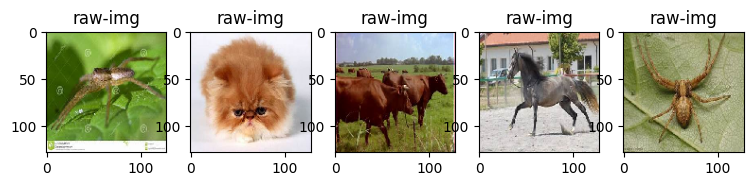

In [20]:
# Driver Code
show_sample_images(train_gen)

In [21]:
# Step 4 : Augmenting the images
aug_datagen_display = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [22]:
# Function to get a random image path from a directory
def get_random_image_path(base_path):
  class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
  random_class_dir = random.choice(class_dirs)
  random_class_path = os.path.join(base_path, random_class_dir)
  images = []
  for root, dirs, files in os.walk(random_class_path):
    for file in files:
      if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        images.append(os.path.join(root, file))
  if not images:
      raise IndexError("No image files found in the directory structure.")
  random_image_name = random.choice(images)
  return os.path.join(random_class_path, random_image_name)

In [23]:
# Driver Code
sample_image_path = get_random_image_path(base_dir)
print("Sample Image Path :", sample_image_path)

Sample Image Path : /kaggle/input/animals10/raw-img/pecora/OIP-N0Pa2cnLb-5jazklrAS0jQHaF-.jpeg


In [24]:
# Reshaping the image
img = load_img(sample_image_path, target_size = (128, 128))
x = img_to_array(img)
x = x.reshape((1,) + x.shape) # Reshape it to (1, 128, 128, 3)

In [25]:
# Function for augmenting the image
def show_augmented_images_with_originals(img_array, datagen, num_images = 4):
  plt.figure(figsize = (15, 5))

  # Display the actual image
  plt.subplot(1, num_images + 1, 1)
  # The original image is in 0-255 range, so we normalize for plotting
  plt.imshow(img_array.reshape(128, 128, 3) / 255.0)
  plt.title("Original Image")
  plt.axis('off')

  # Display the augmented images
  i = 2
  for batch in datagen.flow(img_array, batch_size = 1):
    plt.subplot(1, num_images + 1, i)
    # The augmented image is also in 0-255 range, so we will normalize it as well
    plt.imshow(batch[0] / 255.0)
    plt.title(f"Augmented Image {i-1}")
    plt.axis('off')
    i += 1
    if i > num_images + 1:
      break

  plt.suptitle('Sample Original vs Augmented Images')
  plt.show()

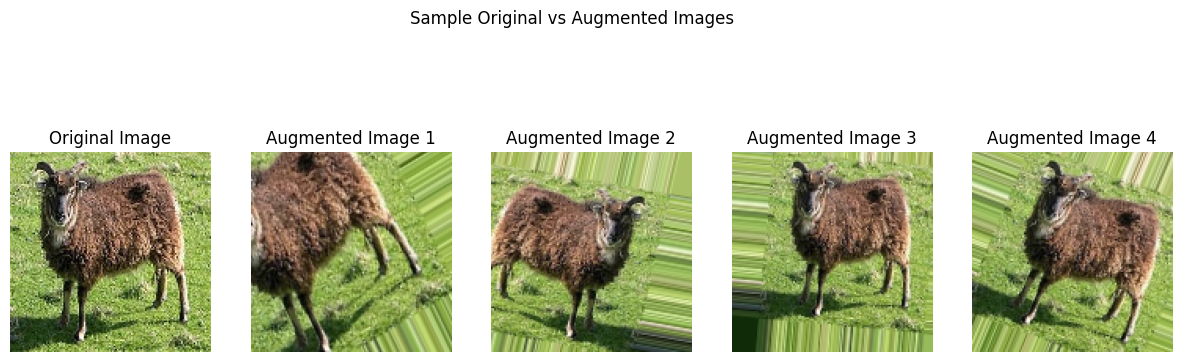

In [26]:
# Driver Code
show_augmented_images_with_originals(x, aug_datagen_display)

In [27]:
# Step 5 : Model Builder Function
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_cnn_model(num_filters = 32, num_hidden = 1, neurons = 64, dropout_rate = 0.3):
  model = Sequential()
  model.add(Conv2D(num_filters, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(num_filters * 2, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  for _ in range(num_hidden):
    model.add(Dense(neurons, activation = 'relu'))
    model.add(Dropout(dropout_rate))

  model.add(Dense(len(train_gen.class_indices), activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [28]:
# Step 6 : Train multiple models
from tensorflow.keras.callbacks import EarlyStopping

configs = [
    {"num_filters" : 32, "num_hidden" : 1, "neurons" : 64, "dropout_rate" : 0.5}, # Increased dropout
    {"num_filters" : 32, "num_hidden" : 2, "neurons" : 128, "dropout_rate" : 0.5}, # Increased dropout
    {"num_filters" : 64, "num_hidden" : 3, "neurons" : 256, "dropout_rate" : 0.7}, # Increased dropout
]

early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

results = []
for cfg in configs:
  model = build_cnn_model(**cfg)
  history = model.fit(train_gen, epochs = 10, validation_data = val_gen,
                      callbacks = [early_stop], verbose = 1)
  val_acc = max(history.history['val_accuracy'])
  results.append((cfg, val_acc))

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 110s 161ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 60s 92ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 47s 72ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 56s 80ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
655/655 ━━━━━━━━━━━━━

In [29]:
# printing the best configuration
print('\nFinal Results')
if results: # Added check for empty results
  for cfg, acc in results:
    print(f"Config {cfg} -> Best Val Accuracy : {acc:.3f}")
else:
  print("No results to display.")


Final Results
Config {'num_filters': 32, 'num_hidden': 1, 'neurons': 64, 'dropout_rate': 0.5} -> Best Val Accuracy : 1.000
Config {'num_filters': 32, 'num_hidden': 2, 'neurons': 128, 'dropout_rate': 0.5} -> Best Val Accuracy : 1.000
Config {'num_filters': 64, 'num_hidden': 3, 'neurons': 256, 'dropout_rate': 0.7} -> Best Val Accuracy : 1.000


In [ ]:
'''
All the three models are equally good on vaildatation dataset.
High accuracy with droput values 0.5 and 0.7  indicate dropout might not even be necessary here
'''


Since we have got goodvalidation report no need to use base model, but for the confirmation and testing i am going ahead with the base model.

In [30]:
# Importing a pretrained model
base_model = tf.keras.applications.VGG16(include_top = False, input_shape = (128, 128, 3), weights = 'imagenet')
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [31]:
# Creating the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_gen.class_indices), activation = 'softmax'))

In [32]:
# Compiling the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [33]:
# Early Stopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [34]:
# Fitting the data
history = model.fit(train_gen, epochs = 10, validation_data = val_gen,
                    callbacks = [early_stop], verbose = 1)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 73s 98ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 54s 82ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
